# Image Digit Classification using Convolutional Neural Networks (CNN)

## DataSet:

the link is [here](https://www.kaggle.com/competitions/digit-recognizer)

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

## Outline:

- **Load the data set**
- **Data Preprocessing**
- **Split the data**
- **What is CNN**
- **implementation with the help of keras**


In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# pd.options.display.max_columns = None

In [2]:
print(os.listdir("../input"))

['digit-recognizer']


In [3]:
print(os.listdir("../input/digit-recognizer"))

['sample_submission.csv', 'train.csv', 'test.csv']


# 1. load the dataset

In [4]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [5]:
train.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


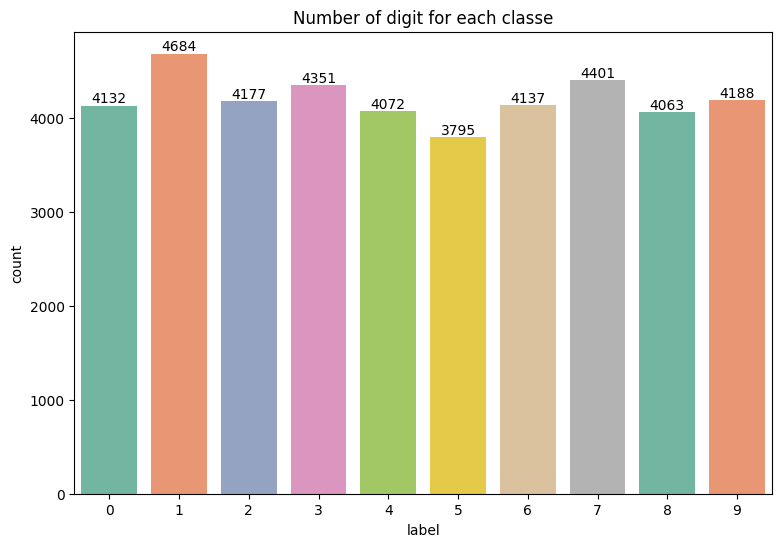

In [6]:
# we will plot the number of digits in each class 

X_train = train.drop(columns=['label'])
y_train = train['label']

plt.figure(figsize=(9,6))
ax = sns.countplot(x=y_train, palette='Set2')
ax.bar_label(ax.containers[0])
plt.title('Number of digit for each classe')

plt.show()

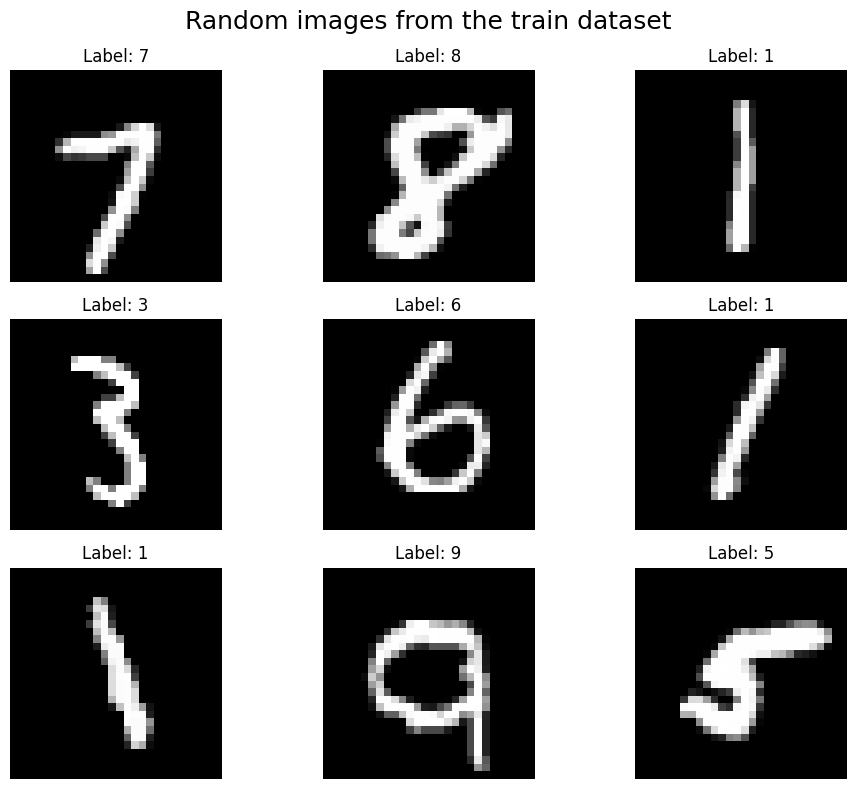

In [7]:
# plot some images 
num_images = 9
plt.figure(figsize=(10,8))
for i, idx in enumerate(np.random.randint(0,len(train), num_images)):
    plt.subplot(3,3,i+1)
    plt.suptitle('Random images from the train dataset',fontsize=18)
    img = X_train.iloc[idx].values
    img = img.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {y_train[idx]}") 
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Data Preprocessing

**Step1: Normalization**

- we perform a grayscale normalization to reduce the effect of illumination's diffrences
- this make our model works faster 

**Step2: Reshape**

- train and test images with (28 x 28) shape
- we will reshape all the data to 3D matrices (28 x 28 x 1)
- this is because keras needs an extra dimension in hte end which correspond to channels. our images are gray scaled so it use only one channel. 

**Step3: Label Encoding**

- encode labels to one hot vectors 
for example the number:
- 1 => ***[0 1 0 0 0 0 0 0 0 0]***
- 4 => ***[0 0 0 0 1 0 0 0 0 0]***

In [8]:
# Noralization
print("Before Normalization:")
print(f"Train Min: {X_train.min().min()} Train Max: {X_train.max().max()}  ")
print(f"Test Min: {test.min().min()} Test Max: {test.max().max()}  ")

X_train = X_train / 255.0
test = test / 255.0
print("After Normalization:")
print(f"Train Min: {X_train.min().min()} Train Max: {X_train.max().max()}  ")
print(f"Test Min: {test.min().min()} Test Max: {test.max().max()}  ")

Before Normalization:
Train Min: 0 Train Max: 255  
Test Min: 0 Test Max: 255  
After Normalization:
Train Min: 0.0 Train Max: 1.0  
Test Min: 0.0 Test Max: 1.0  


In [9]:
# Reshaping

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [10]:
# label encoding
print(f"before the label encoding \n {y_train[0]} \n {y_train[1]}")
y_train = to_categorical(y_train, num_classes= 10)
print(f"after the label encoding \n {y_train[0]} \n {y_train[1]}")


before the label encoding 
 1 
 0
after the label encoding 
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Split the data

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)


print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)


x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


## Convolutional Neural Network

CNN is used for image classification, object detection 

<a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

### What is Convolution Operation?

the convolution operation is like using a magnifying glass (the feature detector) to look closely at an image, focusing on specific features (like edges or shapes) while simultaneously reducing the overall size of the image for faster processing.

1. Input Image and Feature Detectors:

    - Imagine you have a picture (the input image) and you want to find certain features within that picture, like edges or shapes.
    - A feature detector (also called a kernel or filter) is a small matrix (like 3x3, 5x5, or 7x7) that helps to identify these features.
  
2. How It Works:

    - The feature detector slides over the image (this sliding movement is called the stride). At each position, it performs an element-wise multiplication between the values of the image and the values of the filter.
    - After the multiplication, the results are summed up to produce a single output value. This output value represents the strength of the detected feature at that position in the image.
  
3. Feature Maps:

    - The result of applying the feature detector across the entire image creates a feature map. This feature map highlights the areas where the specific feature (detected by the filter) is present.
    - If you use multiple feature detectors, you will end up with multiple feature maps, each highlighting different features of the image.
    
4. Size Reduction:

- The process of convolution reduces the size of the image. While this is useful for speeding up processing time, it also means that some information is lost. This trade-off is important in building efficient models.
    
<a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>

* After having convolution layer we use ReLU to break up linearity. Increase nonlinearity. Because images are non linear.

<a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

### Same Padding
* As we keep applying conv layers, the size of the volume will decrease faster than we would like. In the early layers of our network, we want to preserve as much information about the original input volume so that we can extract those low level features.
* input size and output size are same.

<a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>

### Max Pooling
* It makes down-sampling or sub-sampling (Reduces the number of parameters)
* It makes the detection of features invariant to scale or orientation changes.
* It reduce the amount of parameters and computation in the network, and hence to also control overfitting. 

<a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>

### Flattening

<a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>

### Full Connection
* Neurons in a fully connected layer have connections to all activations in the previous layer
* Artificial Neural Network

<a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

## Implementing with The help of Keras

In [12]:
# model creation

model = Sequential([
    # First convolutional layer
    Conv2D(filters=32,kernel_size= (3, 3), padding='Same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # Second convolutional layer
    Conv2D(64, (3, 3), padding='Same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Third convolutional layer
    Conv2D(128, (3, 3), padding='Same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    # Flatten and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(10, activation='softmax')
])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,306 (1.49 MB)

 Trainable params: 390,858 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Define the optimizer

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Compile the model

- we will use **categorical crossentropy** That means that we have multi class.

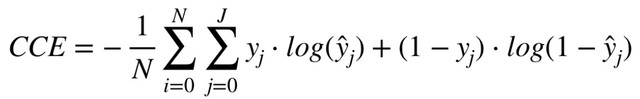

In [14]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Epochs and Batch Size¶

Say you have a dataset of 10 examples (or samples). You have a batch size of 2, and you've specified you want the algorithm to run for 3 epochs. Therefore, in each epoch, you have 5 batches (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations per epoch.

In [15]:
epochs = 100
batch_size = 250

### Data Augmentation

- To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
- Alter the training data with small transformations to reproduce the variations of digit.
- For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.

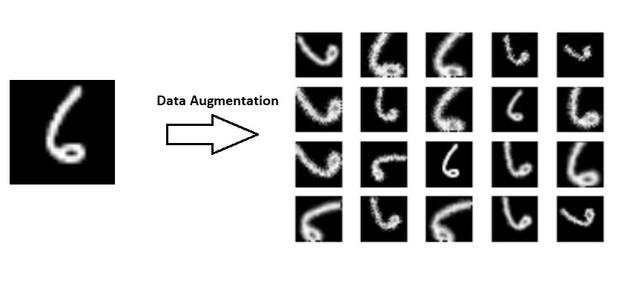

In [16]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [17]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Save the best model based on validation loss
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/100


I0000 00:00:1726268442.057467      67 service.cc:145] XLA service 0x78929c0020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726268442.057542      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/151 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.0939 - loss: 4.8877

I0000 00:00:1726268449.561533      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2742 - loss: 2.2993
Epoch 1: val_loss improved from inf to 6.62293, saving model to best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.2822 - loss: 2.2676 - val_accuracy: 0.1121 - val_loss: 6.6229 - learning_rate: 0.0010
Epoch 2/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7480 - loss: 0.7709
Epoch 2: val_loss did not improve from 6.62293
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7480 - loss: 0.7709 - val_accuracy: 0.1121 - val_loss: 6.7375 - learning_rate: 0.0010
Epoch 3/100
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7675 - loss: 0.7059
Epoch 3: val_loss improved from 6.62293 to 5.11389, saving model to best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7690 - loss: 0.7018 - val_accuracy: 0.1157 - val_loss: 5.1139 - learning_rate: 0.0010
Epoch 4/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8600 - loss: 0.4744
Epoch 4: val_loss di

## Evaluate the model


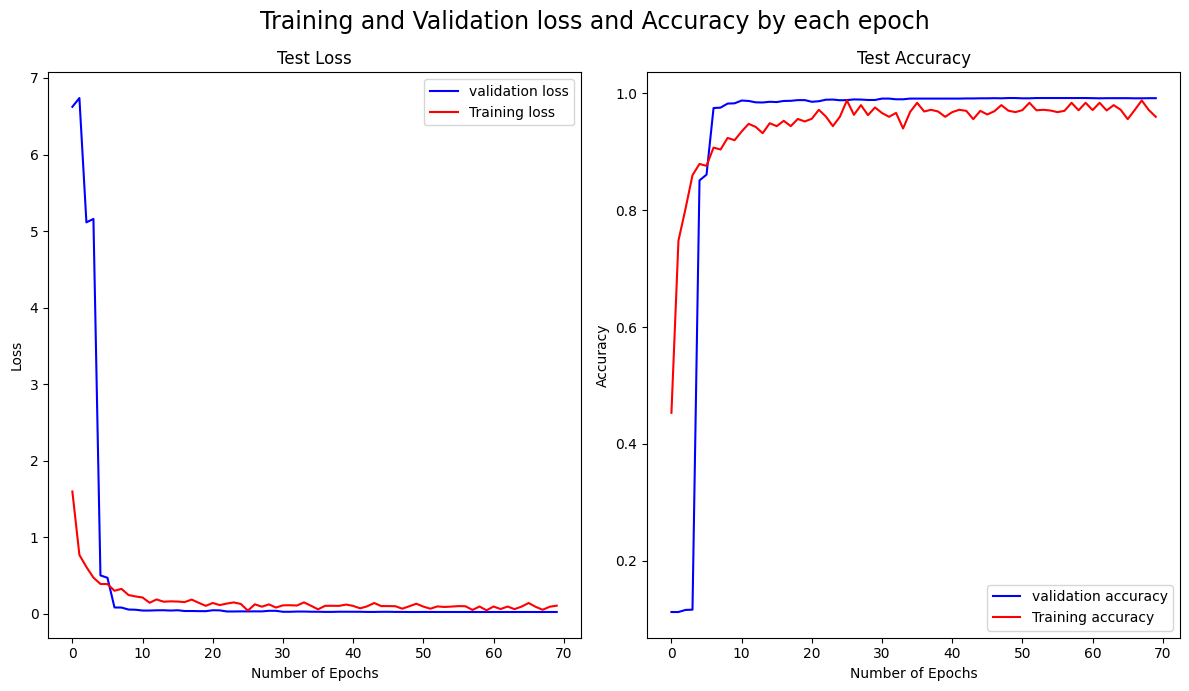

In [18]:
plt.figure(figsize=(12,7))
plt.suptitle("Training and Validation loss and Accuracy by each epoch",fontsize=17)
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")

plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="Training accuracy")

plt.title("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/best_model.keras')

In [20]:
prediction = model.predict(test)
predicted_label = np.argmax(prediction, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [21]:
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(predicted_label) + 1),
    'Label': predicted_label
})

submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!
